<a href="https://colab.research.google.com/github/noureddinekhiati/Game-path-finder/blob/master/KHIATI_SIMILARITY_VGG16_silhouette.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
# for loading/processing the images  
import tensorflow as tf

from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input 

# models 
from tensorflow.keras.applications import VGG16
from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans,MiniBatchKMeans
from sklearn.decomposition import PCA

# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score,f1_score,recall_score,cohen_kappa_score,precision_score,homogeneity_score,silhouette_score


# Defining the model 



*   Je vais  utiliser un dataset aribtraire, exemple : Flower dataset dans Kaggle après on change ça avec notre propore dataset 

*   Ajout de pooling pour réduire la dimension 
*   Utilisation d'un VGG au lieu d'un Resnet 
*   Réduire les dimesnions avec un PCA 
*   application de Kmeans pour culstering










In [2]:
model = VGG16(include_top=True,weights='imagenet',input_shape=(224,224,3),pooling='max')

553476096/553467096 [==============================] - 10s 0us/step


In [3]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [4]:
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!ls

drive  sample_data


In [7]:
base_dir = "/content/drive/My Drive/flowers"

In [8]:
flowers = []

list_of_files = sorted( filter( lambda x: os.path.isfile(os.path.join(base_dir, x)),
                        os.listdir(base_dir) ) )
for file in list_of_files : 
  if file.endswith('.png'):
    flowers.append(file)

In [9]:
flowers

['0001.png',
 '0002.png',
 '0003.png',
 '0004.png',
 '0005.png',
 '0006.png',
 '0007.png',
 '0008.png',
 '0009.png',
 '0010.png',
 '0011.png',
 '0012.png',
 '0013.png',
 '0014.png',
 '0015.png',
 '0016.png',
 '0017.png',
 '0018.png',
 '0019.png',
 '0020.png',
 '0021.png',
 '0022.png',
 '0023.png',
 '0024.png',
 '0025.png',
 '0026.png',
 '0027.png',
 '0028.png',
 '0029.png',
 '0030.png',
 '0031.png',
 '0032.png',
 '0033.png',
 '0034.png',
 '0035.png',
 '0036.png',
 '0037.png',
 '0038.png',
 '0039.png',
 '0040.png',
 '0041.png',
 '0042.png',
 '0043.png',
 '0044.png',
 '0045.png',
 '0046.png',
 '0047.png',
 '0048.png',
 '0049.png',
 '0050.png',
 '0051.png',
 '0052.png',
 '0053.png',
 '0054.png',
 '0055.png',
 '0056.png',
 '0057.png',
 '0058.png',
 '0059.png',
 '0060.png',
 '0061.png',
 '0062.png',
 '0063.png',
 '0064.png',
 '0065.png',
 '0066.png',
 '0067.png',
 '0068.png',
 '0069.png',
 '0070.png',
 '0071.png',
 '0072.png',
 '0073.png',
 '0074.png',
 '0075.png',
 '0076.png',
 '0077.png',

# Data Preprocessing

In [10]:
import os
os.chdir(base_dir)

img = load_img(flowers[0], target_size=(224,224))
# convert from 'PIL.Image.Image' to numpy array
img = np.array(img)

print(img.shape)


(224, 224, 3)


In [11]:
# reshaping the images 
reshaped_img = img.reshape(1,224,224,3)
print(reshaped_img.shape)

(1, 224, 224, 3)


In [12]:

def get_features(file, model):
    # get l'image  224x224 
    img = load_img(file, target_size=(224,224))
    # convertir l'image en numpy
    img = np.array(img) 
    # batch_size = 1, taille = 224x224 , channel = 3
    reshaped_img = img.reshape(1,224,224,3) 
    # passage vers le modele
    imgx = preprocess_input(reshaped_img)
    # get le vecteur de feature
    features = model.predict(imgx, use_multiprocessing=True)
    return features


In [13]:
# boucle sur l'ensemble des images

data = {}

for flower in flowers:
  feat = get_features(flower,model)
  data[flower] = feat

filenames = np.array(list(data.keys()))

# liste des features
feat = np.array(list(data.values()))
feat.shape



(210, 1, 4096)

In [14]:
feat = feat.reshape(-1,4096)
feat.shape

(210, 4096)

# PCA

In [15]:
#application de PCA
pca = PCA(n_components=150, random_state=42)
pca.fit(feat)
x = pca.transform(feat)

# Kmeans 




In [16]:
kmeans = KMeans(n_clusters=10,init='k-means++')
kmeans.fit(x)

KMeans(n_clusters=10)

In [17]:
kmeans.labels_


array([1, 1, 8, 7, 1, 1, 2, 7, 1, 1, 2, 1, 1, 9, 9, 3, 1, 1, 2, 2, 8, 0,
       9, 8, 2, 6, 8, 2, 5, 1, 3, 6, 2, 2, 4, 7, 2, 1, 8, 2, 3, 1, 9, 1,
       1, 0, 9, 1, 7, 1, 4, 0, 9, 3, 1, 6, 2, 1, 2, 7, 8, 1, 9, 1, 2, 2,
       6, 1, 5, 0, 2, 9, 3, 1, 2, 1, 6, 2, 7, 4, 1, 0, 4, 3, 1, 2, 8, 0,
       6, 0, 9, 3, 2, 8, 1, 2, 1, 3, 7, 3, 1, 8, 0, 2, 3, 8, 7, 2, 7, 1,
       2, 0, 8, 3, 2, 1, 7, 6, 2, 1, 2, 8, 0, 2, 3, 1, 8, 1, 1, 6, 2, 8,
       1, 0, 0, 7, 1, 6, 8, 0, 3, 0, 1, 2, 8, 9, 1, 0, 4, 4, 8, 0, 9, 2,
       3, 6, 4, 2, 4, 1, 2, 3, 4, 8, 7, 4, 9, 3, 3, 2, 3, 4, 4, 3, 7, 2,
       1, 0, 8, 9, 1, 2, 7, 5, 1, 1, 3, 7, 4, 8, 0, 9, 1, 2, 7, 4, 6, 2,
       5, 0, 4, 3, 2, 3, 0, 5, 1, 0, 1, 4], dtype=int32)

In [18]:

groups = {}
for file, cluster in zip(filenames,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

In [19]:
def view_cluster(cluster):
    plt.figure(figsize = (25,25));
    files = groups[cluster]
    # Affichage d'un ensemble de 30
    
    # Afficher chaque image dans son cluster 
    for index, file in enumerate(files):
        plt.subplot(10,10,index+1);
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')

['0022.png',
 '0046.png',
 '0052.png',
 '0070.png',
 '0082.png',
 '0088.png',
 '0090.png',
 '0103.png',
 '0112.png',
 '0123.png',
 '0134.png',
 '0135.png',
 '0140.png',
 '0142.png',
 '0148.png',
 '0152.png',
 '0178.png',
 '0191.png',
 '0200.png',
 '0205.png',
 '0208.png']

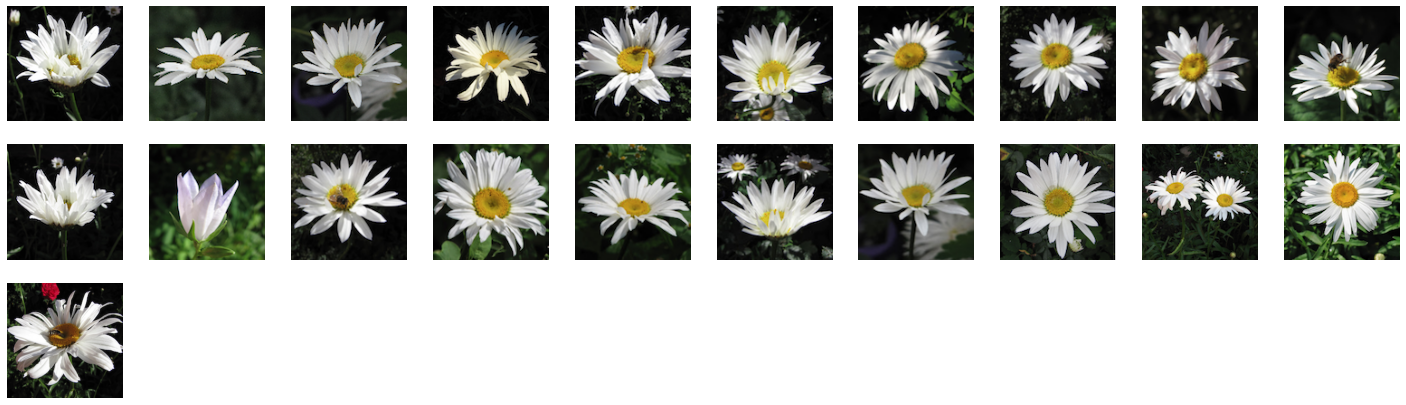

In [20]:
view_cluster(0)
len(groups[0])
groups[0]

['0014.png',
 '0015.png',
 '0023.png',
 '0043.png',
 '0047.png',
 '0053.png',
 '0063.png',
 '0072.png',
 '0091.png',
 '0146.png',
 '0153.png',
 '0167.png',
 '0180.png',
 '0192.png']

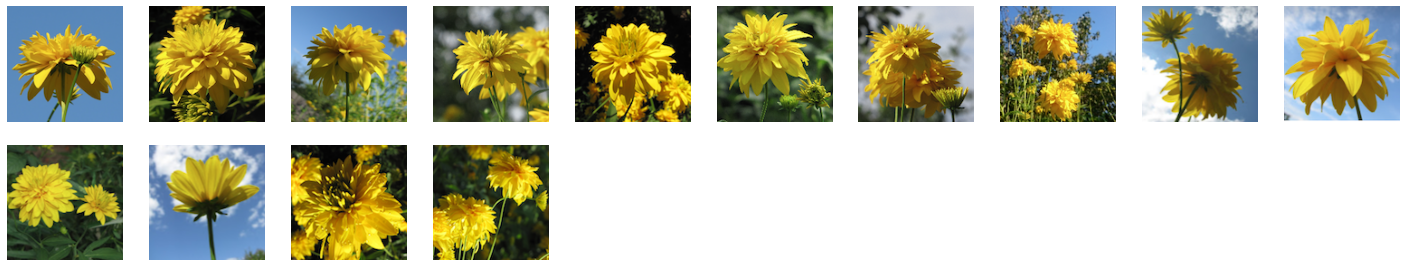

In [21]:
view_cluster(9)
groups[9]

['0016.png',
 '0031.png',
 '0041.png',
 '0054.png',
 '0073.png',
 '0084.png',
 '0092.png',
 '0098.png',
 '0100.png',
 '0105.png',
 '0114.png',
 '0125.png',
 '0141.png',
 '0155.png',
 '0162.png',
 '0168.png',
 '0169.png',
 '0171.png',
 '0174.png',
 '0187.png',
 '0202.png',
 '0204.png']

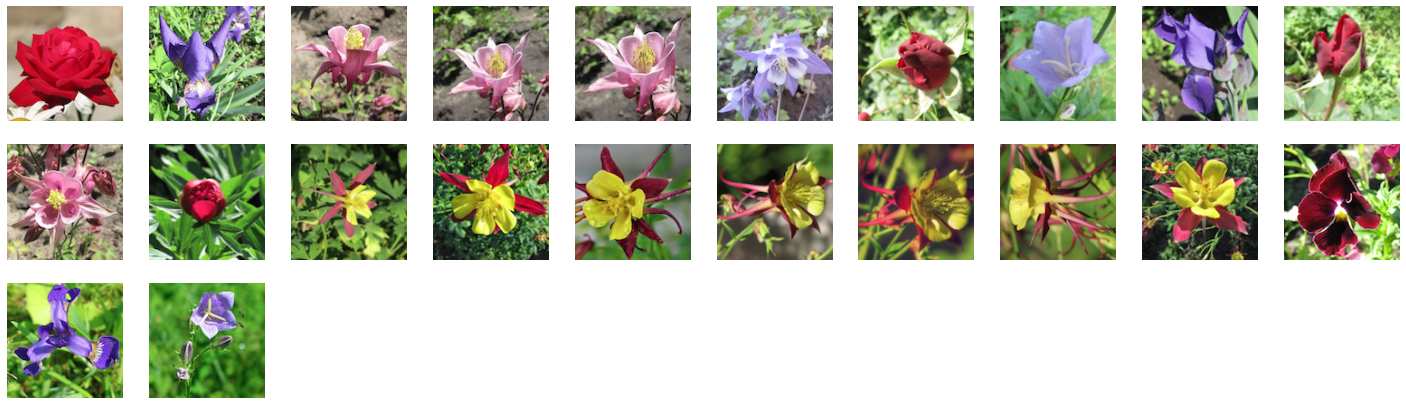

In [22]:
view_cluster(3)
groups[3]

In [23]:
groups[0][0]

'0022.png'

In [24]:
x.shape

(210, 150)

In [25]:
df = pd.read_csv('flower_labels.csv')
label = df['label'].tolist()
y_test = np.array(label)
accuracy_score(kmeans.labels_,y_test)*100



11.428571428571429

In [26]:
filename = df['file'].tolist()
filename

['0001.png',
 '0002.png',
 '0003.png',
 '0004.png',
 '0005.png',
 '0006.png',
 '0007.png',
 '0008.png',
 '0009.png',
 '0010.png',
 '0011.png',
 '0012.png',
 '0013.png',
 '0014.png',
 '0015.png',
 '0016.png',
 '0017.png',
 '0018.png',
 '0019.png',
 '0020.png',
 '0021.png',
 '0022.png',
 '0023.png',
 '0024.png',
 '0025.png',
 '0026.png',
 '0027.png',
 '0028.png',
 '0029.png',
 '0030.png',
 '0031.png',
 '0032.png',
 '0033.png',
 '0034.png',
 '0035.png',
 '0036.png',
 '0037.png',
 '0038.png',
 '0039.png',
 '0040.png',
 '0041.png',
 '0042.png',
 '0043.png',
 '0044.png',
 '0045.png',
 '0046.png',
 '0047.png',
 '0048.png',
 '0049.png',
 '0050.png',
 '0051.png',
 '0052.png',
 '0053.png',
 '0054.png',
 '0055.png',
 '0056.png',
 '0057.png',
 '0058.png',
 '0059.png',
 '0060.png',
 '0061.png',
 '0062.png',
 '0063.png',
 '0064.png',
 '0065.png',
 '0066.png',
 '0067.png',
 '0068.png',
 '0069.png',
 '0070.png',
 '0071.png',
 '0072.png',
 '0073.png',
 '0074.png',
 '0075.png',
 '0076.png',
 '0077.png',

In [27]:
flowers

['0001.png',
 '0002.png',
 '0003.png',
 '0004.png',
 '0005.png',
 '0006.png',
 '0007.png',
 '0008.png',
 '0009.png',
 '0010.png',
 '0011.png',
 '0012.png',
 '0013.png',
 '0014.png',
 '0015.png',
 '0016.png',
 '0017.png',
 '0018.png',
 '0019.png',
 '0020.png',
 '0021.png',
 '0022.png',
 '0023.png',
 '0024.png',
 '0025.png',
 '0026.png',
 '0027.png',
 '0028.png',
 '0029.png',
 '0030.png',
 '0031.png',
 '0032.png',
 '0033.png',
 '0034.png',
 '0035.png',
 '0036.png',
 '0037.png',
 '0038.png',
 '0039.png',
 '0040.png',
 '0041.png',
 '0042.png',
 '0043.png',
 '0044.png',
 '0045.png',
 '0046.png',
 '0047.png',
 '0048.png',
 '0049.png',
 '0050.png',
 '0051.png',
 '0052.png',
 '0053.png',
 '0054.png',
 '0055.png',
 '0056.png',
 '0057.png',
 '0058.png',
 '0059.png',
 '0060.png',
 '0061.png',
 '0062.png',
 '0063.png',
 '0064.png',
 '0065.png',
 '0066.png',
 '0067.png',
 '0068.png',
 '0069.png',
 '0070.png',
 '0071.png',
 '0072.png',
 '0073.png',
 '0074.png',
 '0075.png',
 '0076.png',
 '0077.png',

In [28]:
print(kmeans.labels_)
print(df['label'].tolist())

[1 1 8 7 1 1 2 7 1 1 2 1 1 9 9 3 1 1 2 2 8 0 9 8 2 6 8 2 5 1 3 6 2 2 4 7 2
 1 8 2 3 1 9 1 1 0 9 1 7 1 4 0 9 3 1 6 2 1 2 7 8 1 9 1 2 2 6 1 5 0 2 9 3 1
 2 1 6 2 7 4 1 0 4 3 1 2 8 0 6 0 9 3 2 8 1 2 1 3 7 3 1 8 0 2 3 8 7 2 7 1 2
 0 8 3 2 1 7 6 2 1 2 8 0 2 3 1 8 1 1 6 2 8 1 0 0 7 1 6 8 0 3 0 1 2 8 9 1 0
 4 4 8 0 9 2 3 6 4 2 4 1 2 3 4 8 7 4 9 3 3 2 3 4 4 3 7 2 1 0 8 9 1 2 7 5 1
 1 3 7 4 8 0 9 1 2 7 4 6 2 5 0 4 3 2 3 0 5 1 0 1 4]
[0, 0, 2, 0, 0, 1, 6, 0, 0, 0, 0, 0, 0, 7, 7, 1, 0, 0, 6, 0, 2, 4, 7, 4, 5, 6, 2, 5, 6, 6, 3, 6, 5, 0, 3, 8, 5, 9, 2, 8, 9, 1, 7, 3, 1, 4, 7, 3, 8, 1, 3, 4, 7, 9, 3, 6, 5, 8, 6, 8, 2, 1, 7, 8, 0, 5, 6, 3, 6, 4, 9, 7, 9, 1, 5, 3, 6, 6, 8, 3, 1, 4, 3, 9, 8, 5, 2, 4, 6, 4, 7, 1, 5, 2, 1, 5, 8, 5, 8, 3, 1, 2, 4, 5, 1, 2, 8, 3, 8, 3, 5, 4, 2, 9, 5, 0, 8, 6, 0, 8, 5, 2, 4, 5, 8, 3, 2, 0, 8, 6, 9, 2, 8, 4, 5, 8, 0, 6, 2, 4, 9, 4, 5, 5, 2, 7, 8, 4, 9, 3, 2, 4, 7, 5, 9, 3, 1, 8, 1, 3, 6, 9, 1, 2, 8, 2, 7, 9, 9, 5, 9, 8, 3, 9, 8, 5, 1, 4, 2, 7, 0, 5, 8, 6, 3, 9, 6, 1, 3, 7, 4,

# Perspectives


*   Test sur le dataset de PMA
*   Utilisation de diffrenetes métrique de mesure (Cosine similarity, etc) 
*   Utilisation d'autre algorithmes de clustering (DGB,random forest, etc) 
*   Utilisation d'autre Backbone de NN pour l'extraction des features




In [29]:
label = df['label'].to_numpy()


# Defining metrics 

In [30]:
def classifier_summary(y_test, y_pred_test):

    
    test_accuracy = np.round(accuracy_score(y_test, y_pred_test),4)*100
    test_precision = np.round(precision_score(y_test, y_pred_test, average='weighted'),4)
    test_recall = np.round(recall_score(y_test, y_pred_test, average='weighted'),4)
    test_F1 = np.round(f1_score(y_test, y_pred_test, average='weighted'),4)
    test_kappa =  np.round(cohen_kappa_score(y_test, y_pred_test),4) 
    homogeneity = np.round(homogeneity_score(y_test, y_pred_test),4)
    test_confusion_matrix = confusion_matrix(y_test,y_pred_test)
    

    
    

    
    print()
    print('------------------------ Test Set Metrics------------------------')
    print()
    print("accuracy : {}%".format(test_accuracy))
    print("F1_score : {}".format(test_F1))
    print("Cohen Kappa Score : {} ".format(test_kappa))
    print("Recall : {}".format(test_recall))
    print("Precision : {}".format(test_precision))
    print("Humogeneity : {}".format(homogeneity))
    print("Confusion Matrix : {}".format(test_confusion_matrix))

    print("-"*80)
    print()

    return homogeneity

In [31]:
kmeans.n_clusters

10

In [32]:
def infer_cluster_labels(kmeans, actual_labels):
    """
    Associates most probable label with each cluster in KMeans model
    returns: dictionary of clusters assigned to each label
    """

    inferred_labels = {}

    # Loop through the clusters
    for i in range(kmeans.n_clusters):

        # find index of points in cluster
        labels = []
        index = np.where(kmeans.labels_ == i)

        # append actual labels for each point in cluster
        labels.append(actual_labels[index])

        # determine most common label
        if len(labels[0]) == 1:
            counts = np.bincount(labels[0])
        else:
            counts = np.bincount(np.squeeze(labels))

        # assign the cluster to a value in the inferred_labels dictionary
        if np.argmax(counts) in inferred_labels:
            # append the new number to the existing array at this slot
            inferred_labels[np.argmax(counts)].append(i)
        else:
            # create a new array in this slot
            inferred_labels[np.argmax(counts)] = [i]
        
    return inferred_labels  



In [33]:
def infer_data_labels(Y_labels, cluster_labels):
    """
    Determines label for each array, depending on the cluster it has been assigned to.
    returns: predicted labels for each array
    """
    
    # empty array of len(X)
    predicted_labels = np.zeros(len(Y_labels)).astype(np.uint8)
    
    for i, cluster in enumerate(Y_labels):
        for key, value in cluster_labels.items():
            if cluster in value:
                predicted_labels[i] = key
                
    return predicted_labels

In [34]:


clusters = [10, 16, 36, 64,144,200]
iner_list = []
homo_list = []
acc_list = []

for n_clusters in clusters:
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(x)
    
   
    iner_list.append(kmeans.inertia_)
    
    
    # Determine predicted labels
    cluster_labels = infer_cluster_labels(kmeans, label)
    prediction = infer_data_labels(kmeans.labels_, cluster_labels)
    homo = classifier_summary(label, prediction)
    homo_list.append(homo)

    acc = accuracy_score(label, prediction)
    acc_list.append(acc)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



------------------------ Test Set Metrics------------------------

accuracy : 62.86000000000001%
F1_score : 0.5579
Cohen Kappa Score : 0.5879 
Recall : 0.6286
Precision : 0.5124
Humogeneity : 0.5966
Confusion Matrix : [[18  0  0  0  0  3  0  0  0  0]
 [ 0 14  0  0  0  0  5  0  0  1]
 [ 0  0 18  0  0  0  0  1  0  0]
 [ 4  0  0  0  0  1  5  0  0 12]
 [ 0  0  1  0 20  0  0  0  0  0]
 [ 1  0  0  0  1 21  0  0  0  2]
 [ 3  0  0  0  0  5 14  0  0  1]
 [ 0  0  1  0  0  0  0 14  0  0]
 [14  9  0  0  0  2  0  1  0  0]
 [ 1  1  0  0  0  3  0  0  0 13]]
--------------------------------------------------------------------------------


------------------------ Test Set Metrics------------------------

accuracy : 70.48%
F1_score : 0.696
Cohen Kappa Score : 0.6713 
Recall : 0.7048
Precision : 0.7768
Humogeneity : 0.6161
Confusion Matrix : [[17  0  0  0  0  1  2  0  1  0]
 [ 0 17  0  0  0  1  0  0  2  0]
 [ 0  0 18  0  0  0  0  0  1  0]
 [13  2  0  4  0  1  0  0  1  1]
 [ 0  0  1  0 20  0  0  0  0  

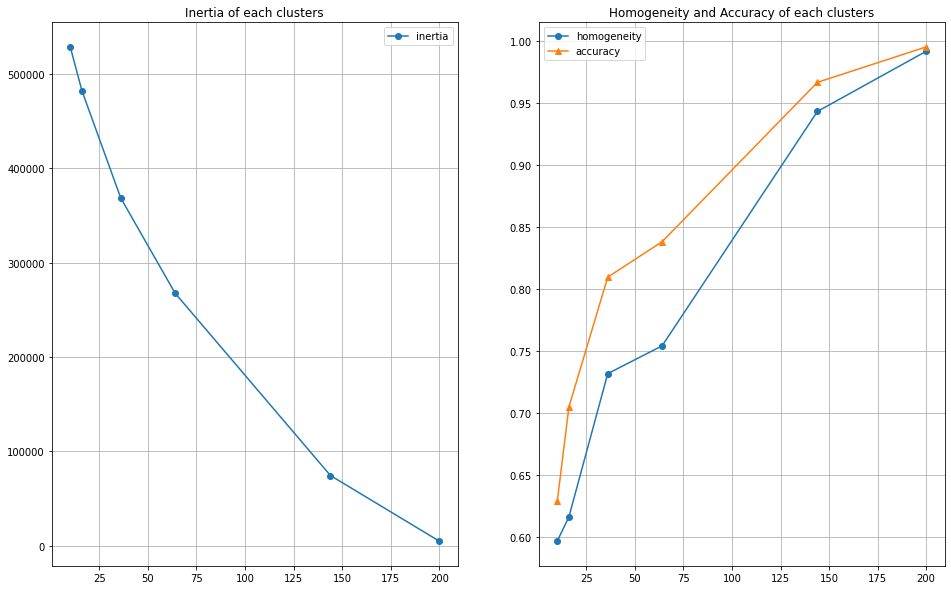

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(16, 10))
ax[0].plot(clusters, iner_list, label='inertia', marker='o')
ax[1].plot(clusters, homo_list, label='homogeneity', marker='o')
ax[1].plot(clusters, acc_list, label='accuracy', marker='^')
ax[0].legend(loc='best')
ax[1].legend(loc='best')
ax[0].grid('on')
ax[1].grid('on')
ax[0].set_title('Inertia of each clusters')
ax[1].set_title('Homogeneity and Accuracy of each clusters')
plt.show()

# Silhouette analysis on KMeans clustering

Num cluster  10  Silhoutte score   =  0.08300529
Num cluster  16  Silhoutte score   =  0.08018094
Num cluster  36  Silhoutte score   =  0.06885586
Num cluster  64  Silhoutte score   =  0.058885913
Num cluster  144  Silhoutte score   =  0.03974877
Num cluster  200  Silhoutte score   =  0.014852912


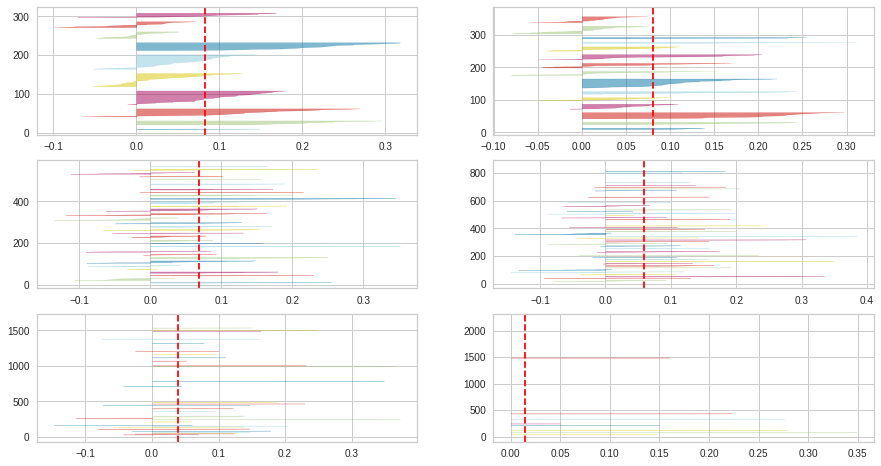

In [51]:
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(3, 2, figsize=(15,8))
j = 2
for i in clusters:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', max_iter=100)
    km.fit(x)
    score = silhouette_score(x, km.labels_, metric='euclidean')
    print('Num cluster ',i,' Silhoutte score   = ',score)
    q, mod = divmod(j, 2)
    j+=1
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(x)

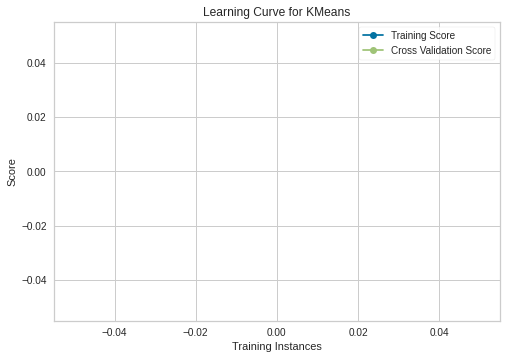

In [57]:

from yellowbrick.model_selection import LearningCurve
visualizer = LearningCurve(km, scoring="adjusted_rand_score", random_state=42)
visualizer.fit(x, label) 
visualizer.show()  

In [48]:
count = [len(groups[i]) for i in groups.keys()]
count

[47, 20, 16, 38, 14, 22, 21, 11, 5, 16]

In [49]:
df.groupby('label').size()

label
0    21
1    20
2    19
3    22
4    21
5    25
6    23
7    15
8    26
9    18
dtype: int64

In [41]:
n_feat = [100,150,200,210]
for n_components in n_feat:
    print('Results for PCA == ',n_components)
    pca = PCA(n_components=n_components, random_state=42)
    pca.fit(feat)
    x = pca.transform(feat)

    kmeans = KMeans(n_clusters=150)
    kmeans.fit(x)
    
   
    iner_list.append(kmeans.inertia_)
    
    
    # Determine predicted labels
    cluster_labels = infer_cluster_labels(kmeans, label)
    prediction = infer_data_labels(kmeans.labels_, cluster_labels)
    homo = classifier_summary(label, prediction)
    homo_list.append(homo)

    acc = accuracy_score(label, prediction)
    acc_list.append(acc)

Results for PCA ==  100

------------------------ Test Set Metrics------------------------

accuracy : 98.1%
F1_score : 0.9808
Cohen Kappa Score : 0.9788 
Recall : 0.981
Precision : 0.9819
Humogeneity : 0.9657
Confusion Matrix : [[20  0  0  0  0  1  0  0  0  0]
 [ 0 20  0  0  0  0  0  0  0  0]
 [ 0  0 19  0  0  0  0  0  0  0]
 [ 0  0  0 21  0  1  0  0  0  0]
 [ 0  0  0  0 21  0  0  0  0  0]
 [ 0  0  0  0  0 25  0  0  0  0]
 [ 0  0  0  0  0  0 23  0  0  0]
 [ 1  0  1  0  0  0  0 13  0  0]
 [ 0  0  0  0  0  0  0  0 26  0]
 [ 0  0  0  0  0  0  0  0  0 18]]
--------------------------------------------------------------------------------

Results for PCA ==  150

------------------------ Test Set Metrics------------------------

accuracy : 96.67%
F1_score : 0.9668
Cohen Kappa Score : 0.9629 
Recall : 0.9667
Precision : 0.968
Humogeneity : 0.9423
Confusion Matrix : [[19  0  0  0  0  1  0  1  0  0]
 [ 0 20  0  0  0  0  0  0  0  0]
 [ 0  0 18  0  0  0  0  1  0  0]
 [ 1  0  0 21  0  0  0  0  0 